# Automated Classification of Human Facial Expressions Using Deep Learning
**Harvard University**<br/>
**Course**: CS 1090B<br/>
**Date**:  May 9, 2025<br/>
**Group Members**: Kachi Ezeani, Jules Niyitegeka, Peter Wanjiru, Eden Seyoum<br/>
**Canvas Project Number**: 44
<hr style="height:2.4pt">


# <a id="contents"></a> Table of Contents

1. [Library Dependencies](#libraries)

2. [Problem Statement](#statement)

3. [Comprehensive EDA Review](#eda)

4. [Modeling](#modeling)

5. [Results](#results)

6. [Conclusion](#conclusion)

7. [Future Work](#future)

In [ ]:
# extracting the zipped file
!unzip -o /content/archive.zip -d /content/Train_Test_datasets

Streaming output truncated to the last 5000 lines.
  inflating: /content/Train_Test_datasets/train/sad/Training_65242339.jpg  
  inflating: /content/Train_Test_datasets/train/sad/Training_65267116.jpg  
  inflating: /content/Train_Test_datasets/train/sad/Training_65275626.jpg  
  inflating: /content/Train_Test_datasets/train/sad/Training_6529266.jpg  
  inflating: /content/Train_Test_datasets/train/sad/Training_65329617.jpg  
  inflating: /content/Train_Test_datasets/train/sad/Training_65338712.jpg  
  inflating: /content/Train_Test_datasets/train/sad/Training_65338797.jpg  
  inflating: /content/Train_Test_datasets/train/sad/Training_65387162.jpg  
  inflating: /content/Train_Test_datasets/train/sad/Training_65404494.jpg  
  inflating: /content/Train_Test_datasets/train/sad/Training_65426218.jpg  
  inflating: /content/Train_Test_datasets/train/sad/Training_65430136.jpg  
  inflating: /content/Train_Test_datasets/train/sad/Training_65437377.jpg  
  inflating: /content/Train_Test_datas

<a id="libraries"></a>

# Library Dependencies


1. Core Libraries:
  - os, shutil, random – File handling, directory management, and randomization

  - pandas, numpy – Data manipulation and numerical operations

  - matplotlib.pyplot, seaborn – Data visualization

2. Image Processing:
  - PIL (Image, ImageEnhance, ImageOps, ImageChops) – Image loading, enhancement, and augmentation

  - tensorflow.keras.preprocessing.image – Image loading and real-time augmentation (ImageDataGenerator, img_to_array, load_img)

3. Model Development (TensorFlow/Keras):
  - tensorflow.keras.models.Sequential – Model building

  - tensorflow.keras.layers – Layers for CNN (e.g., Conv2D, Dense, Dropout, ReLU, etc.)

  - tensorflow.keras.callbacks – Training callbacks (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)

  - tensorflow.keras.optimizers.Adam – Optimizer

  - tensorflow.keras.metrics.AUC – Evaluation metric

4. Machine Learning Tools (scikit-learn)
  - sklearn.preprocessing.LabelEncoder – Label encoding

  - sklearn.model_selection.train_test_split – Train/test split

  - sklearn.metrics – Evaluation (roc_auc_score, roc_curve, auc)

In [ ]:
# importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import random
import shutil
from PIL import Image, ImageEnhance, ImageOps, ImageChops
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc
import time

In [ ]:
#path to train and test datasets
train_dir = "/content/Train_Test_datasets/train/"
test_dir  = "/content/Train_Test_datasets/test/"

<a id="statement"></a>

# Problem Statement

Facial expressions are a universal form of human communication, playing a critical role in conveying emotions. Recognizing these expressions from images has important applications in fields such as human-computer interaction, security, and healthcare technologies. Despite significant progress, building models that can reliably classify human emotions remains a challenge due to the variability and subtlety of facial cues.

Our project focuses on developing a deep learning model to classify facial expressions using the FER-2013 dataset, which contains grayscale images labeled with seven emotional categories: Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral.

Initial exploratory analysis of the dataset highlighted both strengths and challenges. While the dataset is clean and ready for model training, we observed issues such as class imbalance and visual similarity between certain emotional categories, which may lead to confusion during classification. These observations influenced our overall approach, pushing us to prioritize techniques that improve fairness across classes.

As such, we want to build a model that not only performs well but also works reliably across all emotion categories, including those that don't appear as often. In doing so, we hope to take a step toward creating fairer and more reliable emotion recognition systems.

<a id="eda"></a>

# Comprehensive EDA Review

Building upon our initial observations, we conducted a detailed exploratory data analysis (EDA) to inform feature engineering choices and model selection.

### Key Findings from EDA

##### Class Imbalance:

The dataset had significant class imbalance, with the Happy class containing over 7,000 images while the Disgust class had only 436 images. Without correction, this would bias the model toward the majority classes.

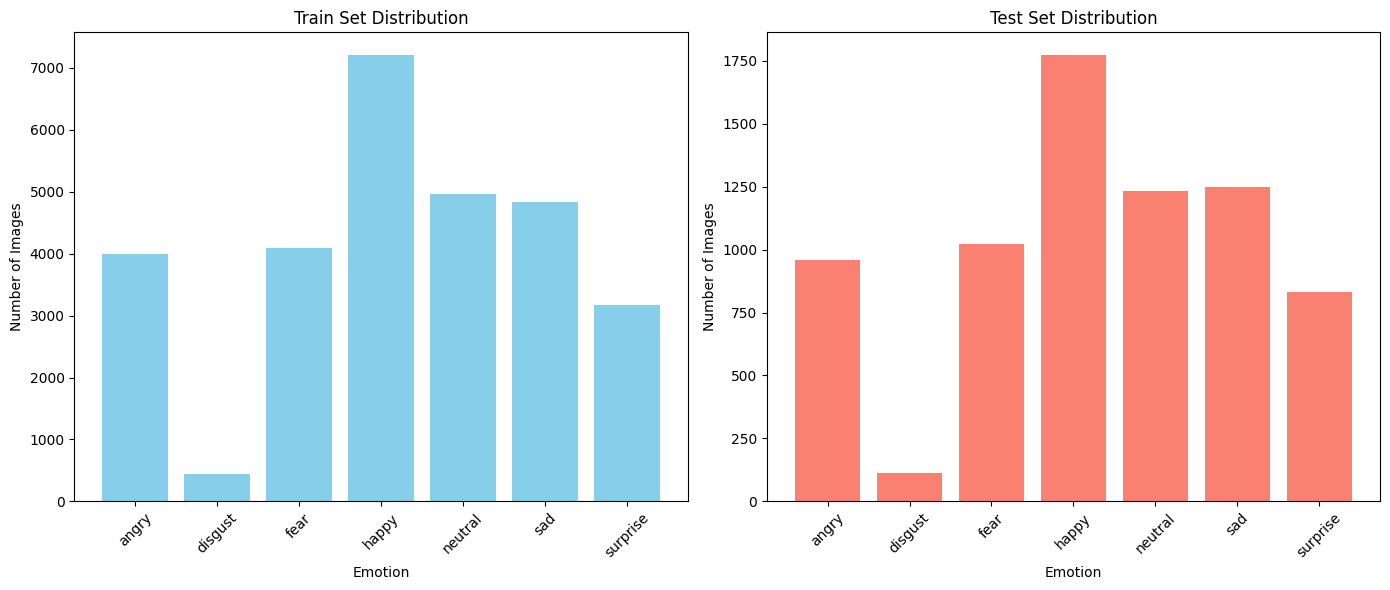

In [ ]:
# class imbalance
# create dictionaries with image counts per class
train_dist = {emotion: len(os.listdir(os.path.join(train_dir, emotion)))
              for emotion in sorted(os.listdir(train_dir))
              if os.path.isdir(os.path.join(train_dir, emotion))}

test_dist = {emotion: len(os.listdir(os.path.join(test_dir, emotion)))
             for emotion in sorted(os.listdir(test_dir))
             if os.path.isdir(os.path.join(test_dir, emotion))}
#figure with 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

#training distribution
axs[0].bar(train_dist.keys(), train_dist.values(), color='skyblue')
axs[0].set_title("Train Set Distribution")
axs[0].set_xlabel("Emotion")
axs[0].set_ylabel("Number of Images")
axs[0].tick_params(axis='x', rotation=45)

#test distribution
axs[1].bar(test_dist.keys(), test_dist.values(), color='salmon')
axs[1].set_title("Test Set Distribution")
axs[1].set_xlabel("Emotion")
axs[1].set_ylabel("Number of Images")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Figure 3.1: The figure shows class distribution in the training (left) and test (right) sets. Happy is the most represented class, while Disgust has the fewest images, highlighting a clear class imbalance.

##### Brightness Variation:
The brightness boxplot revealed that classes like Surprise tended to be brighter, while Sad and Neutral were darker. If uncorrected, the model might associate brightness with specific emotions rather than meaningful facial features.

<ipython-input-5-b42dedb5b9db>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Emotion", y="Brightness", palette="Set3")


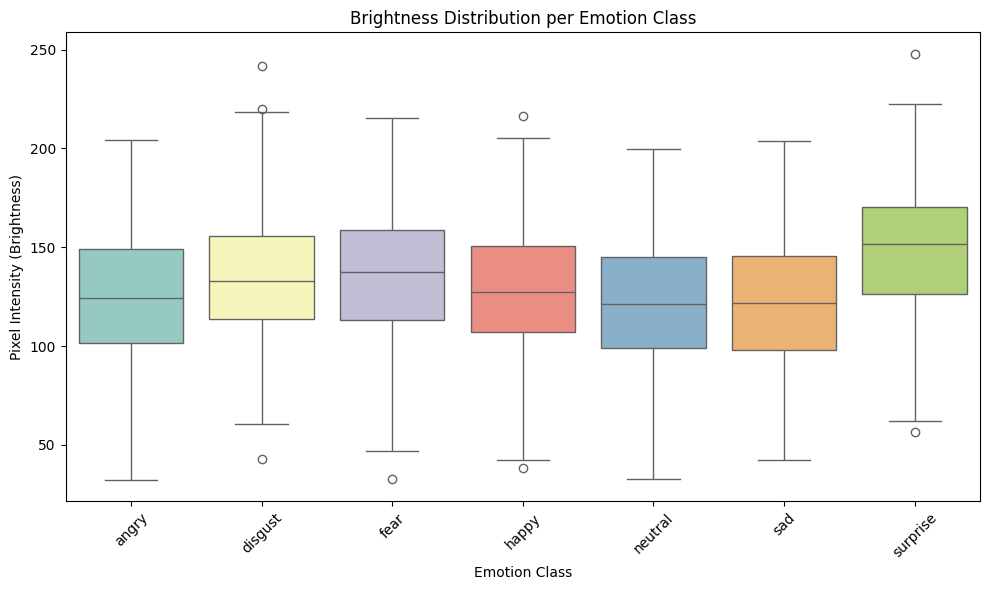

In [ ]:
# code for brightness
#boxplot for each avg brightness of each emotion category
def boxplot_brightness_per_class(data_dir, max_images_per_class=300, random_seed=42):
    """
    Plots a boxplot of image brightness per emotion class.

    Parameters:
        data_dir (str): Root directory containing subfolders of emotion classes.
        max_images_per_class (int): Maximum number of images to process per class.
        random_seed (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: DataFrame containing class and brightness for all processed images.
    """
    random.seed(random_seed)
    data = []

    classes = sorted(os.listdir(data_dir))
    for emotion in classes:
        emotion_path = os.path.join(data_dir, emotion)
        images = os.listdir(emotion_path)

        random.shuffle(images)
        images = images[:max_images_per_class]

        for img_file in images:
            img_path = os.path.join(emotion_path, img_file)
            try:
                img = Image.open(img_path).convert('L')
                brightness = np.mean(np.array(img))
                data.append({"Emotion": emotion, "Brightness": brightness})
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    df = pd.DataFrame(data)

    # plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x="Emotion", y="Brightness", palette="Set3")
    plt.title("Brightness Distribution per Emotion Class")
    plt.xlabel("Emotion Class")
    plt.ylabel("Pixel Intensity (Brightness)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df

brightness_df = boxplot_brightness_per_class(train_dir)

Figure 3.2: The boxplot shows brightness variation across emotion classes. Surprise tends to be brighter, while Sad and Neutral are generally darker.

##### Data Outliers:
A small subset of images were completely black (average brightness = 0). These samples provide no usable information and could confuse the model.

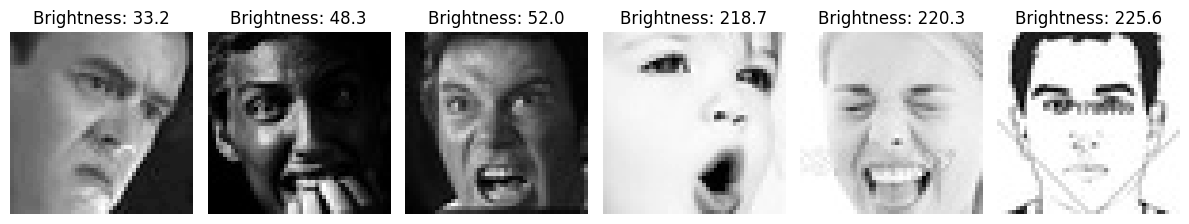

In [ ]:
# data outliers
# checking for outliers
def show_brightness_outliers(data_dir, n=3):
    brightness_scores = []
    file_paths = []

    for emotion in os.listdir(data_dir):
        for img_name in os.listdir(os.path.join(data_dir, emotion))[:100]:  # limit for speed
            img_path = os.path.join(data_dir, emotion, img_name)
            img = Image.open(img_path).convert("L")
            brightness = np.mean(np.array(img))
            brightness_scores.append(brightness)
            file_paths.append(img_path)

    #get darkest and brightest images
    sorted_idx = np.argsort(brightness_scores)
    outliers = [file_paths[i] for i in (list(sorted_idx[:n]) + list(sorted_idx[-n:]))]

    plt.figure(figsize=(12, 3))
    for i, path in enumerate(outliers):
        img = Image.open(path)
        plt.subplot(1, 2*n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Brightness: {round(np.mean(img), 1)}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_brightness_outliers(train_dir)

Figure 3.3: This figure shows sample outliers with extreme brightness levels from the training set, ranging from very dark (0.0) to very bright (225.6), illustrating the variation in image exposure.

##### Facial Alignment and Scale Consistency:
Class-wise average faces highlighted small shifts in eye and mouth positions across classes. Although not immediately addressed, this suggests that a landmark-based alignment step (e.g., centering on eyes) could further improve consistency and expression recognition.

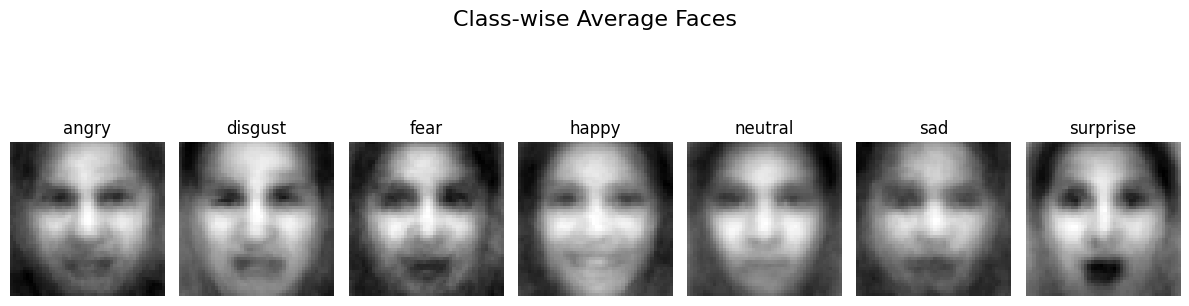

In [ ]:
# average face per emotion class.
# an average image here gives a summary of the most common facial patterns in a class.

def class_wise_average_images(data_dir, max_images_per_class=300):
    avg_images_per_class = {}
    classes = sorted(os.listdir(data_dir))
    img_size = (48, 48)

    plt.figure(figsize=(12, 4))

    for idx, emotion in enumerate(classes):
        emotion_path = os.path.join(data_dir, emotion)
        images = os.listdir(emotion_path)[:max_images_per_class]
        image_stack = []

        for img_file in images:
            img_path = os.path.join(emotion_path, img_file)
            img = Image.open(img_path).convert('L')
            img = img.resize(img_size)
            img_array = np.array(img, dtype=np.float32)
            image_stack.append(img_array)

        if image_stack:
            avg_image = np.mean(image_stack, axis=0)
        else:
            avg_image = np.zeros(img_size)

        avg_images_per_class[emotion] = avg_image

        #plot
        plt.subplot(1, len(classes), idx + 1)
        plt.imshow(avg_image, cmap='gray')
        plt.title(emotion)
        plt.axis('off')

    plt.suptitle("Class-wise Average Faces", fontsize=16)
    plt.tight_layout()
    plt.show()

    return avg_images_per_class
avg_faces = class_wise_average_images(train_dir)

Figure 3.4: This figure shows the average face for each emotion class, capturing common visual features and alignment across the dataset.



<a id="modeling"></a>

# Modeling

## Preprocessing




###  Feature Engineering



To address the challenges identified during EDA, we applied the following feature engineering techniques:

**1. Class Balance Through Targeted Augmentation:**  
We addressed class imbalance by augmenting minority classes until all classes reached 7,215 images, matching the size of the majority class (Happy).  
Our augmentation pipeline involved:
- **Deterministic augmentations**: For each original image, we applied sharpening, horizontal flipping, 30° rotation, and a zoom crop.
- **Random augmentations**: After deterministic steps, if additional images were needed, we randomly applied one of the following to original images: random rotation, horizontal flip, vertical flip, brightness jitter, contrast jitter, or random crops.

This targeted augmentation strategy ensured that underrepresented classes such as Disgust and Fear were synthetically expanded without overfitting to a small set of augmentations.

**2. Handling Brightness Variation:**  
To reduce the risk of models learning to classify based on brightness patterns, we introduced brightness and contrast jitter as part of the random augmentation strategy. This variability forces the model to focus on facial structure rather than lighting artifacts.

**3. Cleaning Data Outliers:**  
Images with extremely low brightness (e.g., fully black) were identified and excluded to prevent the model from encountering unusable inputs during training.

**4. Enhancing Robustness to Pose Variations:**  
By including operations such as random crops and rotations in our augmentation pipeline, we encouraged the model to generalize across slight variations in pose, scale, and alignment that were observed in the average-face analysis.

### Preprocessing Pipeline


To prepare our dataset for modeling, we implemented the following preprocessing steps and have diplayed sample preprocessed images:
-  Image Normalization: All pixel values were scaled to the range [0, 1] using rescale=1./255,  which addresses the feature scaling issue by standardizing the pixel intensity values across all images.
- Data Augmentation: Each class that had fewer images than the class that contained the highest number of images was transformed using sharpening, flipping, rotation, and zooming, generating at least four new images per original. This expanded the dataset while preserving emotion-relevant features.
- Oversampling: after augmentation, we oversampled all other classes to the level of happy class by randomly augmenting, flipping, rotating images to reach a total of 7215 (which was the number of images "Happy" had) images. This helps correct the class imbalance with potential new data points.
- Validation Split: Reserved 20% of the training data for validation using validation_split=0.2.

In [ ]:
#augmentation code
train_dir     = "/content/Train_Test_datasets/train/"
classes       = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
class_counts  = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
target_size   = max(class_counts.values())

def sharpen_image(img):
    return ImageEnhance.Sharpness(img).enhance(2.0)

def generate_augmentations(img):
    sharp = sharpen_image(img)
    return [
        sharp,
        ImageOps.mirror(sharp),
        sharp.rotate(30),
        sharp.crop((6,6,42,42)).resize((48,48))
    ]

def random_augment(img):
    ops = [
        lambda x: x.rotate(random.uniform(-30, 30)),
        lambda x: ImageOps.mirror(x),
        lambda x: ImageOps.flip(x),
        lambda x: ImageEnhance.Brightness(x).enhance(random.uniform(0.8, 1.2)),
        lambda x: ImageEnhance.Contrast(x).enhance(random.uniform(0.8, 1.2)),
        # “chop” = random crop + resize
        lambda x: x.crop((random.randint(0,10), random.randint(0,10),
                          random.randint(38,48), random.randint(38,48))).resize((48,48)),
    ]
    return random.choice(ops)(img)

for cls, orig_count in class_counts.items():
    cls_dir       = os.path.join(train_dir, cls)
    original_files = [
        f for f in os.listdir(cls_dir)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]
    current = original_files.copy()

    #deterministic augmentations
    for fname in original_files:
        if len(current) >= target_size: break
        img = Image.open(os.path.join(cls_dir, fname)).convert("L").resize((48,48))
        for aug in generate_augmentations(img):
            if len(current) >= target_size: break
            newname = f"{cls}_aug_{len(current):05d}.png"
            aug.save(os.path.join(cls_dir, newname))
            current.append(newname)

    #random augmentations from the original set
    while len(current) < target_size:
        src = random.choice(original_files)
        img = Image.open(os.path.join(cls_dir, src)).convert("L").resize((48,48))
        aug = random_augment(img)
        newname = f"{cls}_rand_{len(current):05d}.png"
        aug.save(os.path.join(cls_dir, newname))
        current.append(newname)

    print(f"{cls}: {orig_count} → {len(current)} images")

sad: 4830 → 7215 images
happy: 7215 → 7215 images
angry: 3995 → 7215 images
fear: 4097 → 7215 images
neutral: 4965 → 7215 images
disgust: 436 → 7215 images
surprise: 3171 → 7215 images


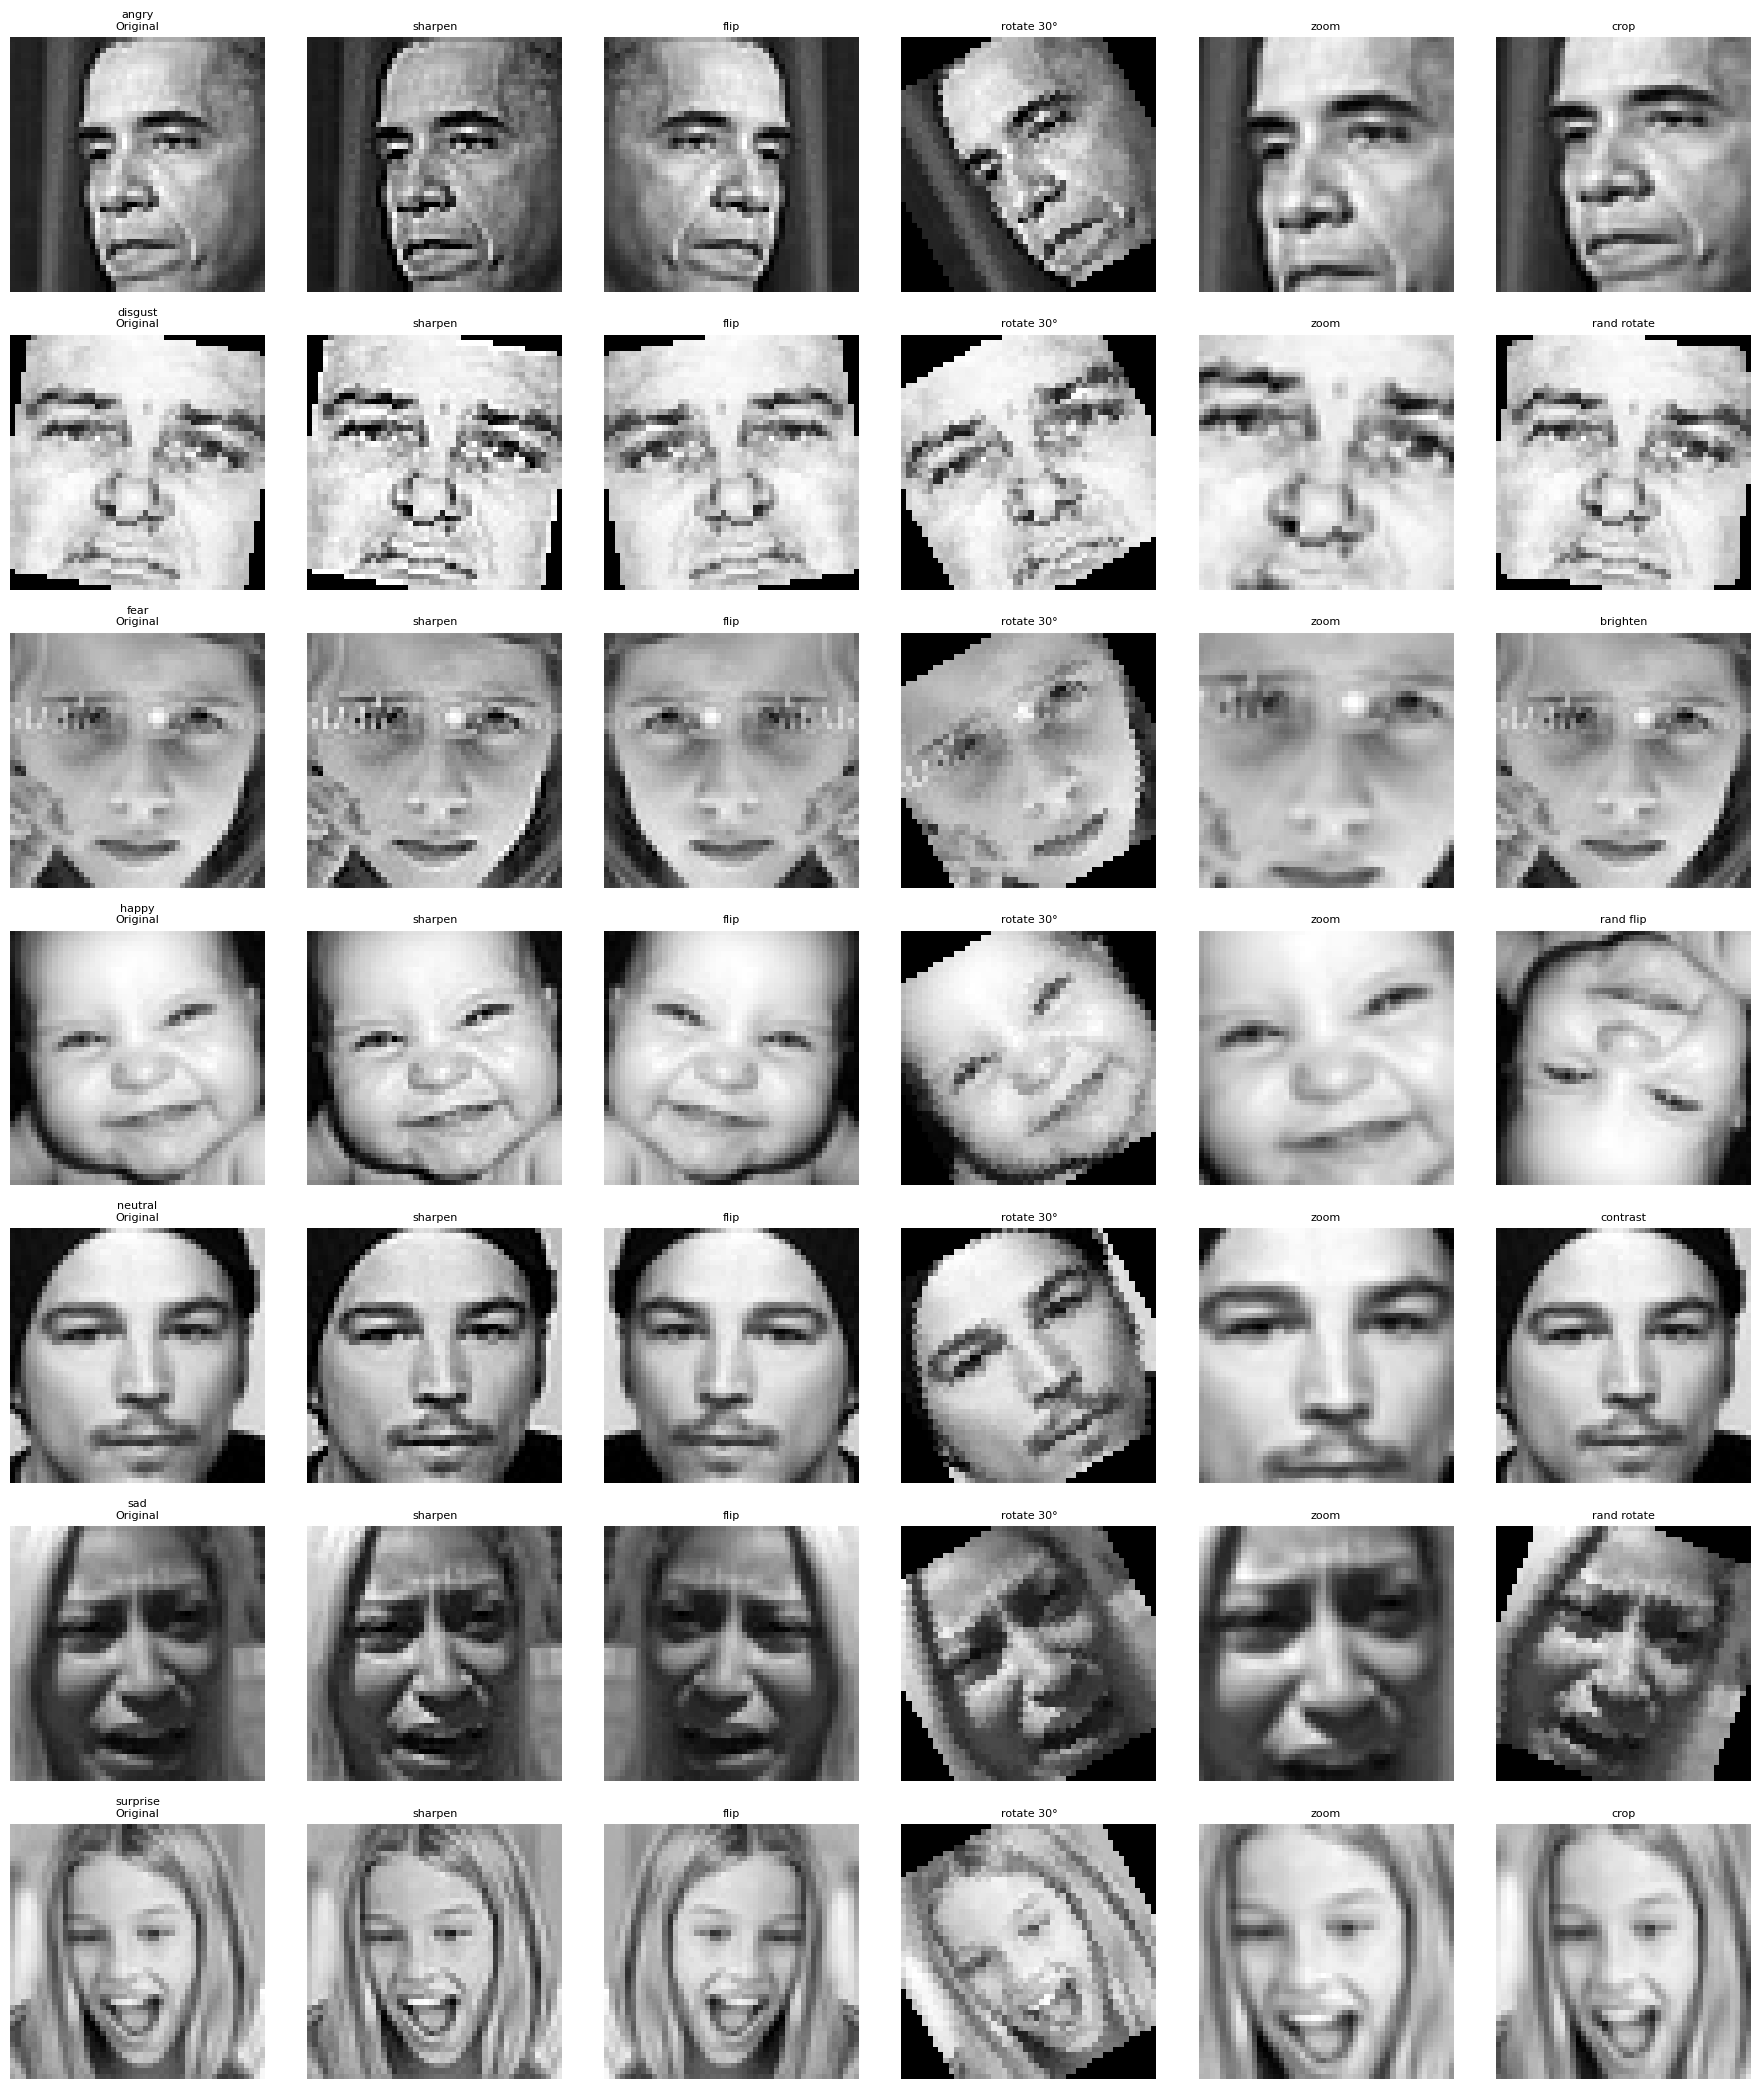

In [ ]:
# Genral preprocessing code
train_dir  = "/content/Train_Test_datasets/train/"
classes    = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
num_fixed  = 4   # six deterministic variants
total_cols = 1 + num_fixed + 1  # original + fixed + one random

fig, axes = plt.subplots(len(classes), total_cols,
                         figsize=(3*total_cols, 3*len(classes)), squeeze=False)

def sharpen(img):
    return ImageEnhance.Sharpness(img).enhance(2.0)

def fixed_variants(img):
    img48 = img.resize((48,48))
    return {
        "orig":          img48,
        "sharpen":       sharpen(img48),
        "flip":          ImageOps.mirror(img48),
        "rotate 30°":    img48.rotate(30),
        "zoom":          img48.crop((6,6,42,42)).resize((48,48))
    }

def random_op(img):
    img48 = img.resize((48,48))
    ops = {
        "rand rotate":   lambda x: x.rotate(random.uniform(-30,30)),
        "rand flip":     lambda x: ImageOps.flip(x),
        "brighten":      lambda x: ImageEnhance.Brightness(x).enhance(random.uniform(0.8,1.2)),
        "contrast":      lambda x: ImageEnhance.Contrast(x).enhance(random.uniform(0.8,1.2)),
        "crop":          lambda x: x.crop((
                              random.randint(0,10),
                              random.randint(0,10),
                              random.randint(38,48),
                              random.randint(38,48))
                            ).resize((48,48))
    }
    name, fn = random.choice(list(ops.items()))
    return name, fn(img48)

for i, cls in enumerate(classes):
    cls_dir   = os.path.join(train_dir, cls)
    originals = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    orig_file = random.choice(originals)
    img       = Image.open(os.path.join(cls_dir, orig_file)).convert("L")

    variants  = fixed_variants(img)
    rand_name, rand_img = random_op(img)

    col = 0
    for name, var_img in variants.items():
        ax = axes[i, col]
        ax.imshow(np.array(var_img), cmap='gray')

        # title the original with the class name, others by operation
        if name == "orig":
            ax.set_title(f"{cls}\nOriginal", fontsize=8)
        else:
            ax.set_title(name, fontsize=8)

        ax.axis('off')
        col += 1

    # plot the random operation
    ax = axes[i, col]
    ax.imshow(np.array(rand_img), cmap='gray')
    ax.set_title(rand_name, fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

Figure 4.1: This figure shows data augmentation examples including sharpening, flipping, rotation, zooming, and cropping, applied to original emotion class images to improve model generalization.

(Training changes)

We already inherited a dataset with train and test data, but we need one further step to create validation data to use during training. We will use 20% of our training data as validation data. We also need to stratify based on the class label to ensure that the validation data represents every emotion well

In [ ]:
# train and validation splits
# dataframe to map images to labels
image_paths = []
labels = []

for cls in classes:
    cls_dir = os.path.join(train_dir, cls)
    files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_paths.extend([os.path.join(cls_dir, f) for f in files])
    labels.extend([cls] * len(files))

# stratified split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels,
    test_size=0.20,
    stratify=labels,
    random_state=42
)

print(f"Training images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")


Training images: 40404
Validation images: 10101


In [ ]:
# code for trianing and validation data frame

train_df = pd.DataFrame({
    'filename': train_paths,
    'class': train_labels
})

val_df = pd.DataFrame({
    'filename': val_paths,
    'class': val_labels
})

In [ ]:
# creates training and validation image generators with rescaling and batching
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 40404 validated image filenames belonging to 7 classes.
Found 10101 validated image filenames belonging to 7 classes.


## Baseline Model

### Parameters and Structure
For our baseline model, we chose to implement a VGG-like model due to its depth and hierarchical learning capabilities. As stated in our problem overview, we want a model that is able to reliably identify all categories regardless of frequency. Of our 7 emotions, there are some pairs like fear and surprise, or anger and sadness, that can be displayed in similar ways with very minor differences. For a model to handle this well, there needs to be different levels of feature extraction to capture general differences and smaller differences. Additionally, as stated in our EDA analysis, our dataset features images with slight variations in scale, rotation and intensity. To deal with this, we want our model to incorporate max pooling to help with translation invariance.

For model structure, we wanted to create a model that was deep enough to capture different complexities of facial features. We felt that four layers was sufficiently deep. We start with only 32 filters and double it for each layer. We did this primarily to prevent the model from overfitting early. Additionally, each convolution layer uses 3x3 filters to capture fine details in facial expressions. The stacking of these filters is what allows the larger-scale details to come out.

After the convolution blocks, we do one more round of global pooling before passing our final representation into a dense layer and applying dropout to combat overfitting.

In [ ]:
def baseline_model(input_shape, num_classes=7):
    model = Sequential()

    model.add(Conv2D(32, (3,3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2,2)))

    for i in range(6, 9):
      model.add(Conv2D(2**i, (3,3), padding='same'))
      model.add(BatchNormalization())
      model.add(ReLU())
      model.add(Conv2D(2**i, (3,3), padding='same'))
      model.add(BatchNormalization())
      model.add(ReLU())
      model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(128))
    model.add(Dropout(0.4))
    model.add(ReLU())
    model.add(Dense(num_classes, activation='softmax'))

    return model
baseline_model = baseline_model(input_shape=(48,48,1), num_classes=7)
baseline_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 256)      │       295,16

 Total params: 1,209,319 (4.61 MB)

 Trainable params: 1,207,399 (4.61 MB)

 Non-trainable params: 1,920 (7.50 KB)

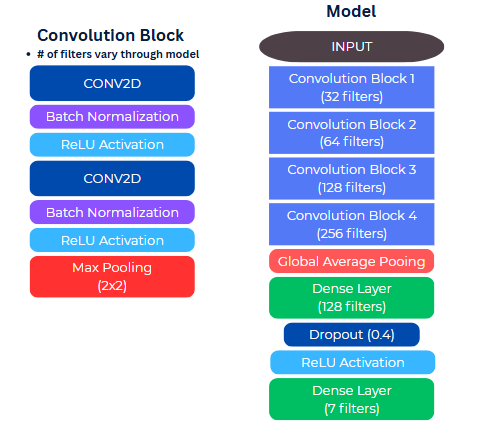

Figure 4.2: This figure summarizes the baseline CNN model architecture, which includes four convolutional blocks, global average pooling, a dense layer with 128 units, dropout, and a final output layer for 7 emotion classes.


### Compiling and Fitting

In [ ]:

baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

start_time = time.time()

baseline_model_history = baseline_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - accuracy: 0.2341 - loss: 1.8750 - val_accuracy: 0.3306 - val_loss: 1.6674
Epoch 2/15
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.4553 - loss: 1.4316 - val_accuracy: 0.5096 - val_loss: 1.2714
Epoch 3/15
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.5456 - loss: 1.2196 - val_accuracy: 0.5307 - val_loss: 1.2850
Epoch 4/15
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5869 - loss: 1.0987 - val_accuracy: 0.5749 - val_loss: 1.1139
Epoch 5/15
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6302 - loss: 0.9882 - val_accuracy: 0.5555 - val_loss: 1.1949
Epoch 6/15
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.6601 - loss: 0.9102 - val_accuracy: 0.6161 - val_loss: 1.0392
Epoch 7/15
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6909 - loss: 0.8244 - val_accuracy: 0.5187 - val_loss: 1.4304
Epoch 8/15
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.7207 - loss: 0.75

In [ ]:
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60

print(f"Training Baseline Model took {minutes} minute(s) and {seconds:.2f} second(s).")

Training Baseline Model took 6 minute(s) and 2.39 second(s).


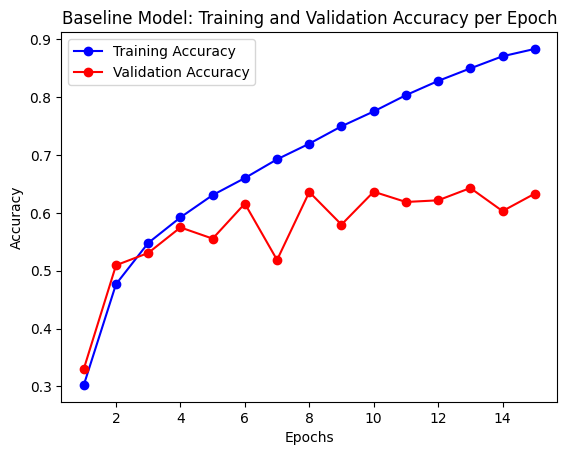

In [ ]:
# Extract accuracy values
acc = baseline_model_history.history['accuracy']                # Training accuracy
val_acc = baseline_model_history.history['val_accuracy']        # Validation accuracy

# Extract number of epochs
epochs = range(1, len(acc) + 1)

# Plot
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Baseline Model: Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Figure 6.1: This plot shows training and validation accuracy across epochs for the baseline model. While training accuracy improves steadily, validation accuracy fluctuates, suggesting potential overfitting.

In [ ]:
best_val_acc = max(baseline_model_history.history['val_accuracy'])
best_epoch = baseline_model_history.history['val_accuracy'].index(best_val_acc) + 1
print(f"Baseline Model's Best Validation Accuracy: {best_val_acc *100 :.4f} at Epoch {best_epoch}")

Baseline Model's Best Validation Accuracy: 64.3006 at Epoch 13


### Baseline Evaluation

For initial evaluation, we will use basic accuracy to see how many the model correctly classifies. However, it is also very important to evaluate the model on a class-by-class basis. To do this, we will also create a confusion matrix, and calculate precision, recall and F1 scores. The confusion matrix will allow us to see which classes are commonly confused with others, giving us a better understanding of how to proceed. For example, if our confusion matrix shows that anger tends to be confused with sadness, we will know we are in a better place than if anger was confused with happiness. Precision, recall, and F1 will help us in evaluating the rarer emotions like disgust and fear. We will be able to see if rarer classes are still handled well.

In [ ]:
# test dataset
test_dir = "/content/Train_Test_datasets/test/"
test_paths = []
test_labels = []
for cls in classes:
    cls_dir = os.path.join(test_dir, cls)
    for f in os.listdir(cls_dir):
        if f.lower().endswith(('.png','.jpg','.jpeg')):
            test_paths.append(os.path.join(cls_dir, f))
            test_labels.append(cls)

test_df = pd.DataFrame({'filename': test_paths, 'class': test_labels})
test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(48,48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 7178 validated image filenames belonging to 7 classes.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluate on the test set
loss, acc = baseline_model.evaluate(test_generator, verbose=1)

# Predict & build arrays
y_pred_proba = baseline_model.predict(test_generator, verbose=1)
y_pred       = y_pred_proba.argmax(axis=1)
y_true       = test_generator.classes
class_names  = list(test_generator.class_indices.keys())

# Overall metrics DataFrame
metrics_df = pd.DataFrame({
    'test_loss':       [loss],
    'test_accuracy':   [acc],
    'sklearn_accuracy':[accuracy_score(y_true, y_pred)]
})

# Classification report DataFrame
report_dict = classification_report(y_true, y_pred,
                                    target_names=class_names,
                                    output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Display
print("\n=== Baseline Model: Overall Metrics ===")
display(metrics_df)

print("\n=== Basline Model: Classification Report ===")
display(report_df)

 11/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2511 - loss: 3.5171

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4551 - loss: 2.4620
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step

=== Baseline Model: Overall Metrics ===


,test_loss,test_accuracy,sklearn_accuracy
0,1.827462,0.574533,0.574533



=== Basline Model: Classification Report ===


,precision,recall,f1-score,support
angry,0.682152,0.291232,0.408193,958.000000
disgust,0.358407,0.729730,0.480712,111.000000
fear,0.557778,0.245117,0.340570,1024.000000
happy,0.788043,0.817362,0.802435,1774.000000
neutral,0.408856,0.771290,0.534420,1233.000000
sad,0.464105,0.368083,0.410555,1247.000000
surprise,0.696162,0.785800,0.738270,831.000000
accuracy,0.574533,0.574533,0.574533,0.574533
macro avg,0.565072,0.572659,0.530736,7178.000000
weighted avg,0.602369,0.574533,0.557408,7178.000000


from matplotlib import pyplot as plt
report_df['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
report_df['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
report_df['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
report_df['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
report_df.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
report_df.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
report_df.plot(kind='scatter', x='f1-score', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
report_df['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
report_df['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
report_df['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
report_df['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

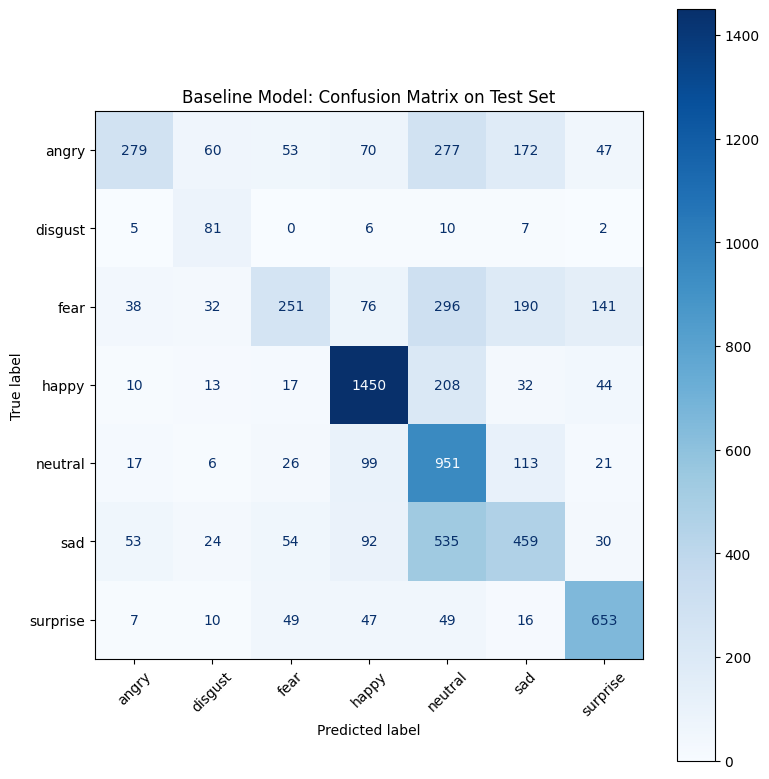

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Baseline Model:Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

Figure 6.2: This confusion matrix shows the baseline model’s performance on the test set, with strongest accuracy for Happy and Neutral classes, and notable misclassifications among Fear, Sad, and Angry emotions.

The model achieves 57.45% accuracy on the test set with a reduced loss of 1.83. Class‐specific performance has improved notably for angry (recall ≈ 0.68) and disgust (recall ≈ 0.73).





Strengths:

	•	Better handling of previously under‐recognized classes (anger, disgust) thanks to targeted balancing/augmentation.
	•	High precision/recall on “happy” (F1 ≈ 0.80) and “surprise” (F1 ≈ 0.74) demonstrates robustness on clear expressions.

Weaknesses:

	•	“Fear” still lags (F1 ≈ 0.34), suggesting that subtle, high‐variability cues remain challenging.
	•	Moderate confusions persist between neutral/sad and fear/sad, so nuance between low‐arousal emotions is still under‐captured.


Confusion Matrix:


*   Neutral is heavily confused with fear and sad. Happy is predicted quite accurately suggesting it's more distinct in the feature space. Even though disgust has low counts, our base model still does a good job with 81 correct prediction?
*   We might need to improve our model to better extract features.




## Final Model:


### Model Improvements

#### Model Architecture:
1. Potential use of Pre-trained Networks (Transfer Learning)?

We could consider using one (or an ensemble) of pre-trained networks like VGG16, ResNet, Inception, or EfficientNet. These networks are highly powerful and can extract meaningful features that our baseline model might not. With some fine-tuning of our chosen pre-trained model, we aim to significantly improve the feature extraction part of our network and potentially boost performance.

It is important to note that most of the pre-trained models are designed for 3-channel (RGB) images, but we have grayscale images.
However, we can either modify the input layer to accept 1-channel (grayscale) images or convert our grayscale images to RGB.

Modifying pre-trained models to accept grayscale images and retraining the entire model is a lot of work and could introduce complexities. We would have to fine-tune the model and possibly lose the advantages of transfer learning.

With our custom model, we are starting fresh, focusing on our specific task.

2. Regularization

While we're already using Dropout, we could experiment with other regularization methods like L2 regularization (weight decay) in the convolutional or dense layers to further control overfitting.

\
#### Training the Network
During training, callbacks can  improve our model performance and help in preventing overfitting or underfitting. Some strategies we aim to employ are:

1. Learning Rate Scheduler

To adjust the learning rate dynamically based on performance, we will introduce a learning rate scheduler to help Adam.

2. Early Stopping

To stop the training if the validation loss stops improving, we will introduce early stopping. This will help prevent any potential overfitting.

3. Model Checkpointing

ModelCheckpoint saves the model weights at the point where the validation loss is lowest. We foresee that training may take some time. Model Checkpointing will prevent us from losing the best version of our model.

4. More Epochs - we will play around with the number of epochs we want to use to ensure our final model is the model that has the best accuracy

\
#### Evaluation of Model performance
We already have several evaluation strategies in the evaluation section above. However, we may leverage one more evaluation strategy from CS1090A known as:
1. Area Under the ROC Curve (AUC-ROC)
Just to recall, the ROC curve shows the tradeoff between the True Positive Rate (Recall) and the False Positive Rate across different thresholds. AUC is a great way to evaluate your model’s ability to discriminate between emotion classes. Also, recall that a higher AUC indicates better model performance, as it shows how well the model differentiates between classes.

### Model Layout

In [ ]:
def improved_model(input_shape, num_classes=7, l2_reg=0.001):
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3,3), padding='same', input_shape=input_shape, kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2,2)))

    for i in range(6, 9):
      model.add(Conv2D(2**i, (3,3), padding='same', kernel_regularizer=l2(l2_reg)))
      model.add(BatchNormalization())
      model.add(ReLU())
      model.add(Conv2D(2**i, (3,3), padding='same', kernel_regularizer=l2(l2_reg)))
      model.add(BatchNormalization())
      model.add(ReLU())
      model.add(MaxPooling2D(pool_size=(2,2)))

    # Final layers
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(0.4))
    model.add(ReLU())
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Compile the model
final_model = improved_model(input_shape=(48, 48, 1), num_classes=7)
final_model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 6, 6, 256)      │       295,16

 Total params: 1,209,319 (4.61 MB)

 Trainable params: 1,207,399 (4.61 MB)

 Non-trainable params: 1,920 (7.50 KB)

### Compiling and Fitting

In [ ]:
# Compile
final_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]


start_time = time.time()


# Train
history = final_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)



# # Train the model with callbacks
# final_history = final_model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=50,
#     callbacks=[early_stopping, model_checkpoint, reduce_lr]
# )


Epoch 1/100
1261/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2288 - loss: 2.4786

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.83541, saving model to best_model.h5


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - accuracy: 0.2289 - loss: 2.4779 - val_accuracy: 0.3358 - val_loss: 1.8354 - learning_rate: 0.0010
Epoch 2/100
1261/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3974 - loss: 1.7716
Epoch 2: val_loss improved from 1.83541 to 1.77546, saving model to best_model.h5


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.3975 - loss: 1.7716 - val_accuracy: 0.4007 - val_loss: 1.7755 - learning_rate: 0.0010
Epoch 3/100
1260/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4629 - loss: 1.6445
Epoch 3: val_loss improved from 1.77546 to 1.71425, saving model to best_model.h5


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.4629 - loss: 1.6444 - val_accuracy: 0.4275 - val_loss: 1.7142 - learning_rate: 0.0010
Epoch 4/100
1261/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4959 - loss: 1.5649
Epoch 4: val_loss improved from 1.71425 to 1.69158, saving model to best_model.h5


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.4959 - loss: 1.5649 - val_accuracy: 0.4388 - val_loss: 1.6916 - learning_rate: 0.0010
Epoch 5/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5144 - loss: 1.5182
Epoch 5: val_loss did not improve from 1.69158
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.5144 - loss: 1.5182 - val_accuracy: 0.3824 - val_loss: 1.8381 - learning_rate: 0.0010
Epoch 6/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5358 - loss: 1.4625
Epoch 6: val_loss improved from 1.69158 to 1.51293, saving model to best_model.h5


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.5358 - loss: 1.4625 - val_accuracy: 0.5128 - val_loss: 1.5129 - learning_rate: 0.0010
Epoch 7/100
1262/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5513 - loss: 1.4188
Epoch 7: val_loss did not improve from 1.51293
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.5513 - loss: 1.4188 - val_accuracy: 0.4799 - val_loss: 1.6056 - learning_rate: 0.0010
Epoch 8/100
1260/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5650 - loss: 1.3842
Epoch 8: val_loss improved from 1.51293 to 1.43002, saving model to best_model.h5


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.5650 - loss: 1.3843 - val_accuracy: 0.5509 - val_loss: 1.4300 - learning_rate: 0.0010
Epoch 9/100
1262/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5786 - loss: 1.3553
Epoch 9: val_loss did not improve from 1.43002
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.5786 - loss: 1.3553 - val_accuracy: 0.5057 - val_loss: 1.5730 - learning_rate: 0.0010
Epoch 10/100
1260/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5970 - loss: 1.3259
Epoch 10: val_loss did not improve from 1.43002
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.5969 - loss: 1.3260 - val_accuracy: 0.5272 - val_loss: 1.5148 - learning_rate: 0.0010
Epoch 11/100
1260/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6053 - loss: 1.3105
Epoch 11: val_loss improved from 1.43002 to 1.37731, saving model to best_model.h5


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.6053 - loss: 1.3106 - val_accuracy: 0.5697 - val_loss: 1.3773 - learning_rate: 0.0010
Epoch 12/100
1262/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6159 - loss: 1.2881
Epoch 12: val_loss did not improve from 1.37731
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.6159 - loss: 1.2881 - val_accuracy: 0.5541 - val_loss: 1.4805 - learning_rate: 0.0010
Epoch 13/100
1262/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6242 - loss: 1.2829
Epoch 13: val_loss improved from 1.37731 to 1.36269, saving model to best_model.h5


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.6242 - loss: 1.2829 - val_accuracy: 0.5894 - val_loss: 1.3627 - learning_rate: 0.0010
Epoch 14/100
1261/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6346 - loss: 1.2622
Epoch 14: val_loss improved from 1.36269 to 1.32205, saving model to best_model.h5


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.6346 - loss: 1.2622 - val_accuracy: 0.6057 - val_loss: 1.3220 - learning_rate: 0.0010
Epoch 15/100
1261/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6398 - loss: 1.2540
Epoch 15: val_loss did not improve from 1.32205
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.6398 - loss: 1.2540 - val_accuracy: 0.5937 - val_loss: 1.3383 - learning_rate: 0.0010
Epoch 16/100
1262/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6503 - loss: 1.2337
Epoch 16: val_loss did not improve from 1.32205
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.6503 - loss: 1.2337 - val_accuracy: 0.5651 - val_loss: 1.4798 - learning_rate: 0.0010
Epoch 17/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6501 - loss: 1.2267
Epoch 17: val_loss did not improve from 1.32205
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.6501 - loss: 1.2267 - val_accuracy: 0.5732 - val_loss: 1.4344 - learning_rate: 0.0010
Epo

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.7250 - loss: 1.0256 - val_accuracy: 0.6354 - val_loss: 1.2498 - learning_rate: 5.0000e-04
Epoch 22/100
1261/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7404 - loss: 0.9824
Epoch 22: val_loss did not improve from 1.24979
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.7404 - loss: 0.9824 - val_accuracy: 0.6215 - val_loss: 1.3079 - learning_rate: 5.0000e-04
Epoch 23/100
1262/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.9440
Epoch 23: val_loss did not improve from 1.24979
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.7500 - loss: 0.9441 - val_accuracy: 0.6136 - val_loss: 1.3640 - learning_rate: 5.0000e-04
Epoch 24/100
1261/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7583 - loss: 0.9308
Epoch 24: val_loss did not improve from 1.24979
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.7583 - loss: 0.9308 - val_accuracy: 0.6018 - val_loss: 1.4237 - learning_rate

 The improved model shares the same architecture as the baseline model but adds L2 regularization to all convolutional and dense layers. It also uses training callbacks—EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint—for better generalization and stability.

In [ ]:
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60

print(f"Training took {minutes} minute(s) and {seconds:.2f} second(s).")

Training took 13 minute(s) and 40.46 second(s).


<a id="results"></a>

# Results


### Accuracy

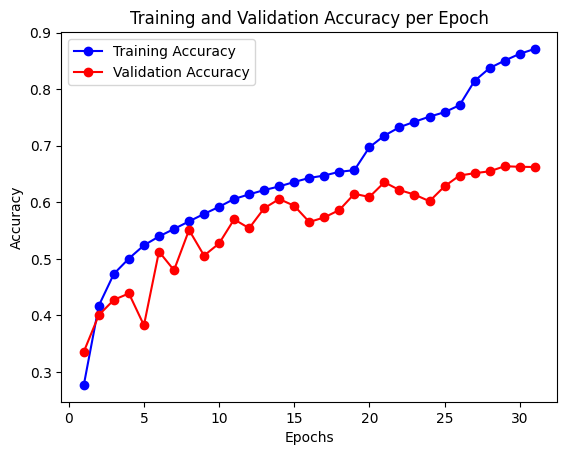

In [ ]:
# Extract accuracy values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract number of epochs
epochs = range(1, len(acc) + 1)

# Plot
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Figure 6.3: Training and validation accuracy over epochs for the improved model, showing more stable performance and higher overall accuracy than the baseline.

In [ ]:
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
print(f"Best Validation Accuracy: {best_val_acc *100 :.4f} at Epoch {best_epoch}")

Best Validation Accuracy: 66.3697 at Epoch 29


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
# Evaluate on the test set
loss, acc = final_model.evaluate(test_generator, verbose=1)

# Predict & build arrays
y_pred_proba = final_model.predict(test_generator, verbose=1)
y_pred       = y_pred_proba.argmax(axis=1)
y_true       = test_generator.classes
class_names  = list(test_generator.class_indices.keys())

# Overall metrics DataFrame
metrics_df = pd.DataFrame({
    'test_loss':       [loss],
    'test_accuracy':   [acc],
    'sklearn_accuracy':[accuracy_score(y_true, y_pred)]
})

# Classification report DataFrame
report_dict = classification_report(y_true, y_pred,
                                    target_names=class_names,
                                    output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Display
print("\n=== Overall Metrics ===")
display(metrics_df)

print("\n=== Classification Report ===")
display(report_df)

225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4869 - loss: 1.5928
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step

=== Overall Metrics ===


,test_loss,test_accuracy,sklearn_accuracy
0,1.393407,0.590972,0.590972



=== Classification Report ===


,precision,recall,f1-score,support
angry,0.604200,0.390397,0.474318,958.000000
disgust,0.356436,0.648649,0.460064,111.000000
fear,0.426810,0.270508,0.331142,1024.000000
happy,0.834231,0.785795,0.809289,1774.000000
neutral,0.564019,0.564477,0.564248,1233.000000
sad,0.417501,0.635124,0.503817,1247.000000
surprise,0.703091,0.766546,0.733448,831.000000
accuracy,0.590972,0.590972,0.590972,0.590972
macro avg,0.558041,0.580214,0.553761,7178.000000
weighted avg,0.604026,0.590972,0.587030,7178.000000


### Confusion Matrix

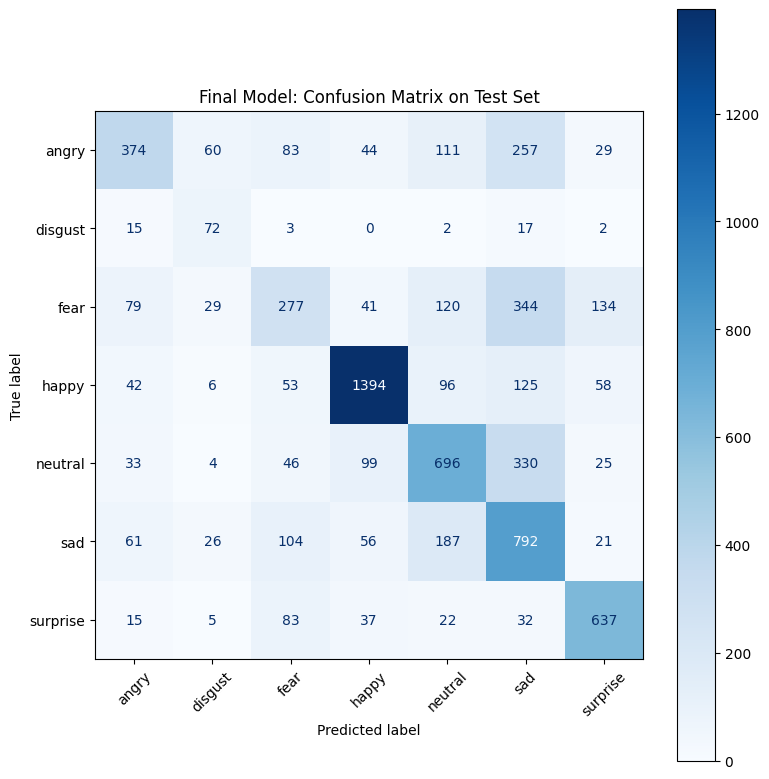

In [ ]:
# Compute confusion matrix
final_cm = confusion_matrix(y_true, y_pred)

# Create display object
disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Final Model: Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

Figure 6.2: This confusion matrix shows the final model’s performance on the test set, with strongest accuracy for Happy and Sad classes, and notable misclassifications among Fear, Sad, and Angry emotions.

### Analysis

Interpretation:

- Final model improved recall for most emotions, specifically Angry and Sad. The final model is better at detecting actual cases of these emotions.

- Final model was less reliable to identify fear, perhaps due to confusion with similar expressions like surprise or sadness.

- Disgust’s precision remained low. Both models were over-predicting Disgust, catching most true cases but frequently mislabeling other emotions as Disgust (recall Disgust was the least test observations)

- Final model trades off a bit of precision to gain recall aiming for better sensitivity across all emotions


Confusion Matrix:

*   Neutral is heavily confused with most other emotions. Happy is predicted quite accurately suggesting it's more distinct in the feature space. Disgust has very low counts, but our base model still does a good job with 81 correct prediction?


<a id="conclusion"></a>

#Conclusion


- Developed facial emotion classifiers using FER-2013, starting from a VGG-style baseline and improving with a deeper CNN architecture.

- Oversampled the underrepresented classes, especially to address the data imbalance in the Disgust class,  to 7215 images using five augmentations (sharpen, flip, rotate, zoom, crop).

- Final model improved accuracy from 57.45% → 59.72%, with Angry recall rising from 0.29 → 0.47 and Disgust recall from 0.72 → 0.77, though Disgust precision stayed low.

- Confusion matrices showed fewer misclassifications as Neutral, indicating improved feature extraction.

- Regularization, adaptive learning rate, and early stopping in the final model helped reduce overfitting.

- Although Fear was no longer significantly classified as Neutral, it still remained challenging to classify, getting classified as sadness.







<a id="future"></a>

# Future Work



- Add attention layers so the model focuses on the most important parts of the face, especially for recognizing Disgust.

- Improve accuracy by training on larger emotion datasets like AffectNet and using transfer learning.

- Use GANs to create more diverse training images and check model fairness across different groups of people.

- Use facial landmarks or combine CNNs with sequence models to help tell Fear and Surprise apart.



Zoom presentation link: https://harvard.zoom.us/rec/share/8ebxOZDIIRmvJMLLpQ2IejNWPmdD6sHro4zUb7GZiZTjRmg7-xoP6Mdr-ErJG3SB.VasoiUEj8ctdRj1d?startTime=1746831294000
